# Relax Inc. - what factors predict user adoption?



"adopted user" = logged in for 3 separate days in at least 1 seven-day period. 

In [1]:
pip install dython

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [63]:
import pandas as pd
import numpy as np
import sklearn as sk
from datetime import datetime
from datetime import timedelta
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

### Read files

In [2]:
users = pd.read_csv('./takehome_users.csv', encoding='latin1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [5]:
user_engagement = pd.read_csv('./takehome_user_engagement.csv')

In [6]:
user_engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


### Calculate each week in the time_stamp feature and add column

In [8]:
user_engagement['wk'] = pd.to_datetime(user_engagement['time_stamp']).dt.week

user_engagement.head()

C:\Users\Linds\AppData\Local\Temp\ipykernel_16224\3545506174.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  user_engagement['wk'] = pd.to_datetime(user_engagement['time_stamp']).dt.week


,time_stamp,user_id,visited,wk
0,2014-04-22 03:53:30,1,1,17
1,2013-11-15 03:45:04,2,1,46
2,2013-11-29 03:45:04,2,1,48
3,2013-12-09 03:45:04,2,1,50
4,2013-12-25 03:45:04,2,1,52


create dataframe of counts for each time a user logged-in per week and call counts "freq". Then create new dataframe with counts of users who logged in 3 or more times are included.

In [9]:
df = user_engagement.groupby(['wk', 'user_id'])['time_stamp'].count().reset_index(name="freq")

result = df[df.freq >=3]


In [10]:
result

,wk,user_id,freq
1,1,10,5
2,1,42,4
5,1,63,7
6,1,69,10
7,1,81,3
...,...,...,...
57164,52,11939,5
57165,52,11957,4
57166,52,11959,3
57169,52,11969,3


Only list each unique ID once. 

In [11]:
adopters = result['user_id'].unique()


In [12]:
adopters

array([   10,    42,    63, ...,  4134, 10446, 10335], dtype=int64)

In [13]:
len(adopters)

1445

1445 "adopters" found 

In [14]:
adopters = pd.DataFrame(adopters, columns= ['user_id'])

In [15]:
adopters

,user_id
0,10
1,42
2,63
3,69
4,81
...,...
1440,8809
1441,725
1442,4134
1443,10446


Create column where being an adaptor is 1 else 0.

In [16]:
adopters['adopters'] = 1

In [17]:
adopters

,user_id,adopters
0,10,1
1,42,1
2,63,1
3,69,1
4,81,1
...,...,...
1440,8809,1
1441,725,1
1442,4134,1
1443,10446,1


### Megre adtopters dataframe with User dataframe for EDA and modeling

Make sure merge field in both dataframes are the titled the same. 

In [18]:
adopters['object_id'] = adopters['user_id']

In [19]:
adopters.head()

,user_id,adopters,object_id
0,10,1,10
1,42,1,42
2,63,1,63
3,69,1,69
4,81,1,81


In [21]:
adopter_factors = pd.merge(adopters, users, on="object_id", how= "right")
adopter_factors.head()
adopter_factors

,user_id,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,NaN,NaN,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2.0,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,NaN,NaN,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,NaN,NaN,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,NaN,NaN,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,NaN,NaN,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,NaN,NaN,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,NaN,NaN,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,NaN,NaN,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


Remove features we don't need 

In [22]:
adopter_factors.drop(columns= 'user_id')

,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,NaN,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,NaN,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,NaN,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,NaN,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,NaN,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,NaN,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,NaN,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,NaN,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [23]:
adopter_factors.drop("user_id", axis=1, inplace=True)

In [24]:
adopter_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopters                    1445 non-null   float64
 1   object_id                   12000 non-null  int64  
 2   creation_time               12000 non-null  object 
 3   name                        12000 non-null  object 
 4   email                       12000 non-null  object 
 5   creation_source             12000 non-null  object 
 6   last_session_creation_time  8823 non-null   float64
 7   opted_in_to_mailing_list    12000 non-null  int64  
 8   enabled_for_marketing_drip  12000 non-null  int64  
 9   org_id                      12000 non-null  int64  
 10  invited_by_user_id          6417 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.1+ MB


Fill adopters columns NaN values with 0

In [25]:
adopter_factors['adopters']= adopter_factors['adopters'].fillna(0)

Check for other null values or duplicates

In [27]:
adopter_factors.isnull().values.any()

True

In [28]:
adopter_factors.isnull().sum()

adopters                         0
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

Handle nulls in user_id invites column by imputing zero to signfiy not available.

In [29]:
adopter_factors['invited_by_user_id'] = adopter_factors['invited_by_user_id'].fillna(0)

Impute missing session creation time columns with mean value

In [31]:
adopter_factors['last_session_creation_time'] = adopter_factors['last_session_creation_time'].fillna(adopter_factors['last_session_creation_time'].mean())

In [32]:
adopter_factors.isnull().sum()

adopters                      0
object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

In [34]:
adopter_factors

,adopters,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,0.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,0.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,0.0,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,0.0,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,0.0,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0
11997,0.0,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,0.0,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0


Free of duplicate user entries that we know of and missing values. 

Test correlation on all features with pearsons heatmap

Categorical feature prep with dython library. Inspired by this [medium article](https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26)

In [71]:
categorical_features=identify_nominal_columns(adopter_factors)

categorical_features

[]

In [ ]:
associations(adopter_factors, nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson',  ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver',cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)

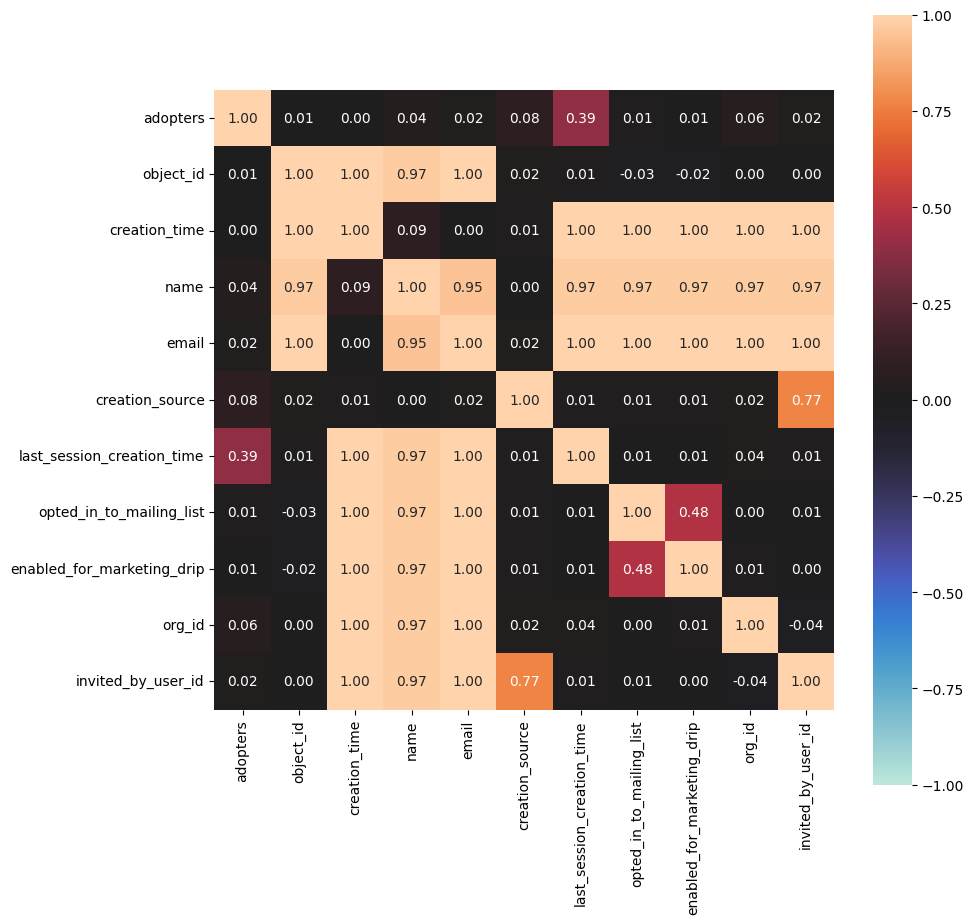

In [372]:
complete_correlation= associations(adopter_factors, filename= 'complete_correlation.png', figsize=(10,10))

In [35]:
adopter_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopters                    12000 non-null  float64
 1   object_id                   12000 non-null  int64  
 2   creation_time               12000 non-null  object 
 3   name                        12000 non-null  object 
 4   email                       12000 non-null  object 
 5   creation_source             12000 non-null  object 
 6   last_session_creation_time  12000 non-null  float64
 7   opted_in_to_mailing_list    12000 non-null  int64  
 8   enabled_for_marketing_drip  12000 non-null  int64  
 9   org_id                      12000 non-null  int64  
 10  invited_by_user_id          12000 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.1+ MB


Formate the creation_time feature into a datetime srting

In [36]:
adopter_factors['creation_time'] = pd.to_datetime(adopter_factors['creation_time'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')

In [37]:
adopter_factors.creation_time.info()

<class 'pandas.core.series.Series'>
Int64Index: 12000 entries, 0 to 11999
Series name: creation_time
Non-Null Count  Dtype         
--------------  -----         
0 non-null      datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 187.5 KB


Make it numerical for modeling

In [38]:
adopter_factors['creation_time'] = pd.to_numeric(adopter_factors['creation_time'])

Remove unecessary categorical features name and email

In [40]:
adopter_factors.drop("name", axis=1, inplace=True)

In [41]:
adopter_factors.drop("email", axis=1, inplace=True)

In [42]:
adopter_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopters                    12000 non-null  float64
 1   object_id                   12000 non-null  int64  
 2   creation_time               12000 non-null  int64  
 3   creation_source             12000 non-null  object 
 4   last_session_creation_time  12000 non-null  float64
 5   opted_in_to_mailing_list    12000 non-null  int64  
 6   enabled_for_marketing_drip  12000 non-null  int64  
 7   org_id                      12000 non-null  int64  
 8   invited_by_user_id          12000 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 937.5+ KB


encode creation_source feature for modeling

In [43]:
creation_source = pd.get_dummies(adopter_factors['creation_source'],drop_first=True)

In [44]:
creation_source

,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,0,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
11995,1,0,0,0
11996,0,0,0,1
11997,0,0,0,0
11998,0,1,0,0


Add dummy features to the modeling dataframe

In [45]:
frames = [adopter_factors, creation_source]

In [52]:
adopter_factors = pd.concat(frames, axis=1)

In [54]:
adopter_factors.drop("creation_source", axis=1, inplace=True)

In [57]:
adopter_factors['adopters'] = adopter_factors['adopters'].astype('bool')

In [58]:
adopter_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopters                    12000 non-null  bool   
 1   object_id                   12000 non-null  int64  
 2   creation_time               12000 non-null  int64  
 3   last_session_creation_time  12000 non-null  float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          12000 non-null  float64
 8   ORG_INVITE                  12000 non-null  uint8  
 9   PERSONAL_PROJECTS           12000 non-null  uint8  
 10  SIGNUP                      12000 non-null  uint8  
 11  SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
dtypes: bool(1), float64(2), int64(5), uint8(4)
memory usage: 808.6 KB


Classification model to predict adopters for the purpose of obtaining the cooefficents of each feature to plot their importance in predicting adopters. 

In [60]:
X = adopter_factors.drop('adopters', axis=1)
y = adopter_factors['adopters']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [61]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

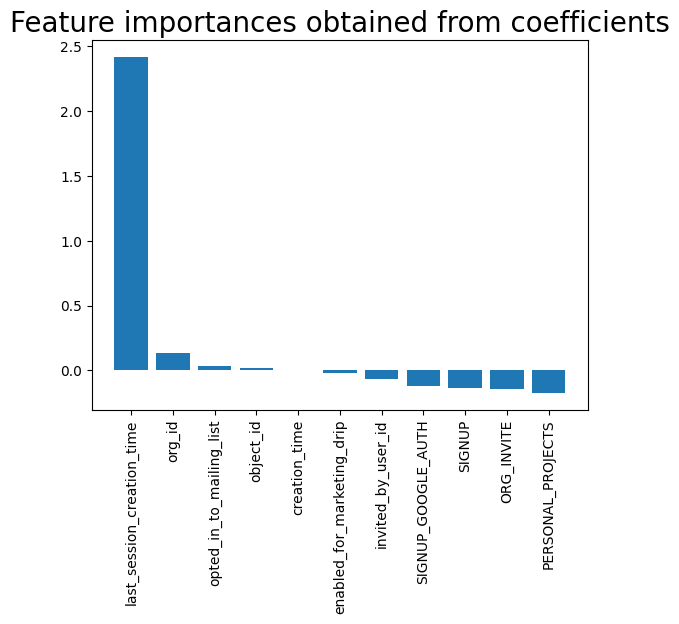

In [67]:
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('Feature Importances', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [74]:
importances

,Attribute,Importance
2,last_session_creation_time,2.418707
5,org_id,0.136559
3,opted_in_to_mailing_list,0.031487
0,object_id,0.015427
1,creation_time,0.000000
4,enabled_for_marketing_drip,-0.020136
6,invited_by_user_id,-0.068667
10,SIGNUP_GOOGLE_AUTH,-0.123149
9,SIGNUP,-0.135440
7,ORG_INVITE,-0.147135


### Findings

Unfortunately the data doesn't offer a feature that is not tied to login sessions that has a significant importance to predicting adopters. Here are some observations that provide a little insight:
* It is obvious that the basic prediction is mostly influeced by the timestamp of the last login. 
* The creation source is interestingly not providing any assistance to the model 
* Whether or not the user is receiving regular marketing email also has no importance impact. Odd
* The organization the users belong to slightly impacts the prediction. But it's influence is minor in comparrison to last login. 
* Barely an influence at all was if the user opted in to the mailing list. 